# NB. Chebyshev Polynomials

> Saleh Rezaeiravesh and Philipp Schlatter <br />
  salehr@kth.se, pschlatt@mech.kth.se <br />
  SimEx/FLOW, KTH Engineering Mechanics, Royal Institute of Technology, Stockholm, Sweden

> This notebook is a part of the [KTH-Nek5000 lecture notes](https://kth-nek5000.github.io/kthNekBook/).


In [1]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from numpy.linalg import norm
import math as mt
pi=mt.pi
#%matplotlib notebook
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (15, 5),
         'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)

## Chebyshev bases and Gauss-Lobatto-Chebyshev points
Chebyshev polynomials are defined as, 

$$
\begin{equation}
T_k(x) = \cos(k \arccos x) \ , \ \ k=0, 1, 2, \ldots \ .
\end{equation}
$$

These polynomials are implemented in the following function:

In [2]:
def chebyBase(k,x):
    """
    Chebyshev basis function
    args:
       `k`: int or a numpy array of int
          Order of the Chebyshev  polynomial
       `x`: numpy array
          points in the physical space
    returns:
       T_k(x): numpy array of size 
    """
    if (isinstance(k,np.ndarray)):
       cheb_=np.cos(np.dot(np.arccos(x),k.T))
    else:
       cheb_=np.cos(k*np.arccos(x))
    return cheb_

We can plot the Chebyshev polynomials up to order `kMax`:

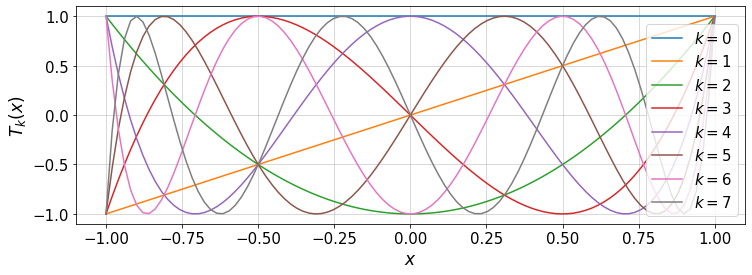

In [3]:
"""
Plot different Chebyshev bases
x\in[-1,1]
"""
kMax=7   #max order of the polynomials - 1
x=np.linspace(-1.,1.,100)[:,None]
k=np.arange(kMax+1)[:,None]
T=chebyBase(k,x)

#plot
plt.figure(figsize=(12,4))
for i in range(k.shape[0]):   #subrange of k
    plt.plot(x,T[:,i],'-',label=r'$k=$'+str(i))
plt.xlabel(r'$x$')
plt.ylabel(r'$T_k(x)$')
plt.legend(loc='lower right')
plt.grid()

There are different options for distributing points for Chebyshev polynomials, including the Gauss-Lobatto-Chebyshev (GLC) points:

$$
\begin{equation}
x_j = \cos \frac{\pi j}{N}\, \quad j=0,1,\cdots N
\end{equation}
$$

which are the extrema of $T_N(x)$. 

In [4]:
def GLC_pts(N):
    """
    Gauss-Lobatto-Chebyshev Points
    args:
       `N`: int, order of the Chebyshev polynomial
    returns:
       numpy array of size N+1 containing the GLC points
    """
    return(np.cos(pi*np.arange(N+1)/N))

Here, we can plot $N+1$ GLC points for a given $N$ (max order of the Chebyshev polynomial):

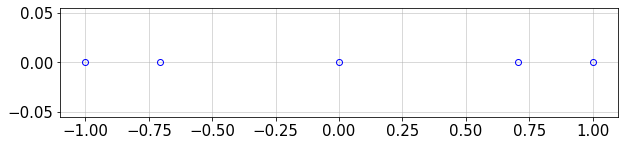

In [5]:
N=4
plt.figure(figsize=(10,2))
plt.plot(GLC_pts(N),np.zeros(N+1),'ob',mfc='none')
plt.grid()

The GLC points are compressed over the boundaries of interval [-1,1] and include the boundary values $\pm 1$.

### Boundary-vanishing basis functions

The Chebyshev basis functions $T_k(x)$ do not vanish at the boundaries $x=\pm 1$. However, we can define a set of basis functions with such property:

$$
\varphi_k(x) = T_{k+2}(x)-T_k(x)\,, \quad k=0,1,\cdots \,.
$$

For instance, 

$$
\varphi_0(x)=2(x^2-1)\,,\quad 
\varphi_1(x)=4x(x^2-1)\,,\quad \cdots
$$

The set of $\varphi_k(x)$ can be useful for Galerkin-type of weighted residual method for solving differential equations. 

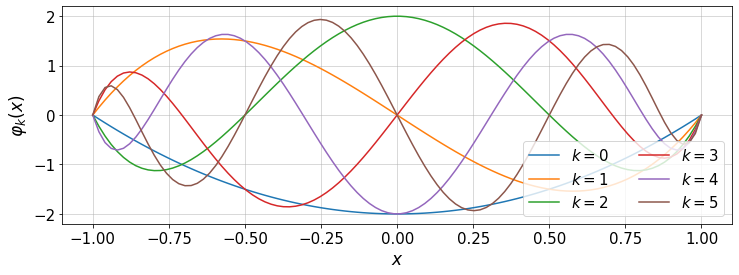

In [6]:
#plot
plt.figure(figsize=(12,4))
for i in range(k.shape[0]-2):   #subrange of k
    plt.plot(x,T[:,i+2]-T[:,i],'-',label=r'$k=$'+str(i))
plt.xlabel(r'$x$')
plt.ylabel(r'$\varphi_k(x)$')
plt.legend(loc='lower right',ncol=2)
plt.grid()

## Interpolation and Runge Phenomenon

Let's use the Chebyshev polynomials with the GLC nodes to construct an interpolant for some function $f(x)$ given a set of nodal values $\{f_i\}_{i=0}^{N}$ where $f_i=f(x_i)$.
The interpolation is written as,

$$
\begin{equation}
\tilde{f}(x) = \sum_{k=0}^{N} \hat{f}_k T_k(x) \,.
\end{equation}
$$
Using the nodal values (collocation methods), vector $\mathbf{F}:=[{f}_0,\cdots,{f}_{N}]^T$ is formed. Therefore, the above summation becomes,

$$
\begin{equation}
\mathbf{F} = \mathbf{T}\hat{\mathbf{F}} \,,
\end{equation}
$$
where, $\hat{\mathbf{F}}:=[\hat{f}_0,\cdots,\hat{f}_{N}]^T$ and $[\mathbf{T}]_{ik} = T_{k-1}(x_{i-1})$ for $i,k=1,\cdots,N+1$. The coefficients $\hat{\mathbf{F}}$ can be computed by inverting $\mathbf{T}$.

This has been implemented in the following function:

In [7]:
# Chebyshev interpolant using collocation method
def cheby_colloc(N,x,f,xTest):
    """
    1. Apply collocation method to compute Chebyshev coefficients
    2. Interpolate function f at `xTest` using Chebyshev bases
    args:
       'N': int, max polynomial order
       `x`: input x, 1d numpy array of size N+1
       `f`: input f at `x`, 1d numpy array of size N+1
       `xTest`: test points at which the approximate `f` is computed via Chebyshev interpolation
    returns:
       `fCheb`: approximate function values at `xTest`, 1d numpy array
    """
    #Coefficients for the Chebyshev expansion
    T=chebyBase(np.arange(N+1)[:,None],x[:,None])    
    a=np.dot(np.linalg.inv(T),f)
    #interpolation at test points
    fCheb=np.zeros(len(xTest))
    for k in range(N+1):
        Tkx=chebyBase(k,xTest)
        fCheb+=a[k]*Tkx
    return fCheb

Now, consider a smooth function $f(x)$ where $x\in[-1,1]$. 
Two nodal sets are considered: equidistant and GLC points. Let's compare the resulting inerpolated $f$ based on same number of samples:

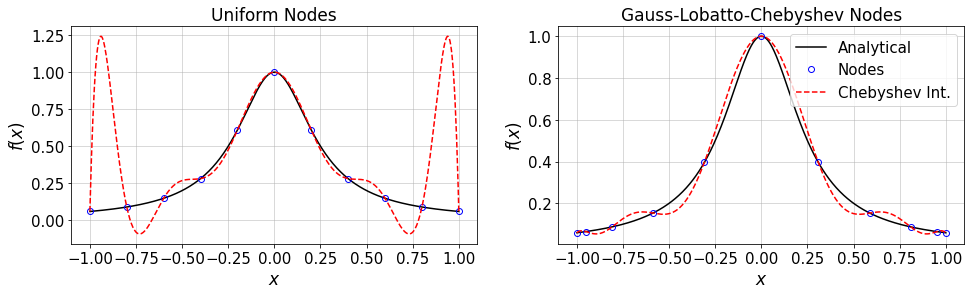

In [8]:
# define the analytical f(x)
f = lambda x: (1./(1+16*x**2.))

#---- Settings
N=10   #max poynomial order
#--------------------
n=N+1   #number of nodes

#generate data
xBound=[-1.,1.]
xUnif=np.linspace(xBound[0],xBound[1],n)
fUnif=f(xUnif)
xCL=GLC_pts(N)
fCL=f(xCL)
xTest=np.linspace(xBound[0],xBound[1],500)

#Collocation method to compute coefficients in the Chebyshev transform
fUnif_cheb=cheby_colloc(N,xUnif,fUnif,xTest)
fCL_cheb=cheby_colloc(N,xCL,fCL,xTest)

#plots
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(xTest,f(xTest),'-k')
plt.plot(xUnif,fUnif,'ob')
plt.plot(xTest,fUnif_cheb,'--r')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.title('Uniform Nodes')
plt.grid()
#
plt.subplot(1,2,2)
plt.plot(xTest,f(xTest),'-k',label='Analytical')
plt.plot(xCL,fCL,'ob',label='Nodes')
plt.plot(xTest,fCL_cheb,'--r',label='Chebyshev Int.')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='best')
plt.title('Gauss-Lobatto-Chebyshev Nodes')
plt.grid()
plt.show()

### Exercise
1. Consider the above analytical function. For different values of $N$ (Chebyshev max order), study the convergence rate of Chebyshev interpolation on both uniform and GLC nodes. 
2. Consider a non-smooth function and redo the above task. 

What are your conclusions?

## Differentiation using Chebyshev Polynomials

The matrix of first-order differentiation, $\mathbf{D}$ can be constructed either:
1. by directly implementing the following explicit formula, 

$$
\begin{equation}
D_{ij} = \left\{\begin{array}{cc}
\frac{c_i}{c_j} \frac{(-1)^{i+j}}{x_i-x_j} \ , & i\neq j \\
- \frac{x_i}{2(1-x_i^2)} \ , & 1\leq i=j \leq N-1 \\
\frac{2 N^2+1}{6} \ , & i=j=0 \\
-\frac{2 N^2+1}{6} \ , & i=j=N \ ,
\end{array} \right.
\end{equation}
$$
with

$$
\begin{equation}
c_{k} = \left\{\begin{array}{cc}
2 \ , & k=0, N \\
1 \ , & 1\leq k \leq N-1 \ .
\end{array} \right.
\end{equation}
$$
2. or, using the generalized formualtion applied in `chebdif.m`, see [Weideman and Reddy](https://web.iitd.ac.in/~mmehra/MATH4Q03/ft_gateway.cfm.pdf). A Python version of `chebdif.m` which is used in this notebook, see below, is taken from [dmsuite](https://github.com/ronojoy/pyddx/blob/master/sc/dmsuite.py), but small modifications have been applied. 

In [30]:
def chebyDiff(n_):
    """
    Direct implementation of the Chebyshev first-order differentiation matrix, D. 
    arg:
       `n_`: number of nodes
    return:   
       `D`: numpy array of shape (N,N), differentiation matrix 
    """
    x_=GLC_pts(n_-1)
    D=np.zeros((n_,n_))
    for j in range(n_):
        for i in range(n_):
            if (i==j):
               if i==0:
                  D[i,j]=(2*(n_-1)**2.+1)/6.
               elif i==n_-1:
                  D[i,j]=-(2*(n_-1)**2.+1)/6.
               else:
                  D[i,j]=-x_[i]/(2*(1-x_[i]**2.))
            else:
               ci=1.0
               cj=1.0
               if (i==0 or i==n_-1):
                  ci=2
               if (j==0 or j==n_-1):
                  cj=2
               D[i,j]=ci*(-1)**(i+j)/(cj*(x_[i]-x_[j]))
    return D

In [31]:
y=GLC_pts(2)
chebyDiff(3)

array([[ 1.500000e+00, -2.000000e+00,  5.000000e-01],
       [ 5.000000e-01, -3.061617e-17, -5.000000e-01],
       [-5.000000e-01,  2.000000e+00, -1.500000e+00]])

`chebdif` taken from [dmsuite](https://github.com/ronojoy/pyddx/blob/master/sc/dmsuite.py):

In [32]:
def chebdif(N,M):
    """
    Chebyshev differentiation matrix up to max order M. 
    args:
       `M`: max order of differentiation
       `N`: number of nodes (should be n in our notation)
    return:   
       `D`: numpy array of shape (M,N,N)
    source: 
       https://github.com/ronojoy/pyddx/blob/master/sc/dmsuite.py
    """
    if M >= N:
        raise Exception('numer of nodes must be greater than M')        
    if M <= 0:
         raise Exception('derivative order must be at least 1')

    DM = np.zeros((M,N,N))    
    
    #n1 = (N/2); n2 = round(N/2.)     # indices used for flipping trick [Original]
    n1 = mt.floor(N/2); n2 = mt.ceil(N/2)     # indices used for flipping trick [Corrected]
    k = np.arange(N)                    # compute theta vector
    th = k*np.pi/(N-1)    

    # Compute the Chebyshev points
    #x = np.cos(np.pi*np.linspace(N-1,0,N)/(N-1))                # obvious way   
    x = np.sin(np.pi*((N-1)-2*np.linspace(N-1,0,N))/(2*(N-1)))   # W&R way
    x = x[::-1]
    
    # Assemble the differentiation matrices
    T = np.tile(th/2,(N,1))
    DX = 2*np.sin(T.T+T)*np.sin(T.T-T)               # trigonometric identity
    DX[n1:,:] = -np.flipud(np.fliplr(DX[0:n2,:]))    # flipping trick
    DX[range(N),range(N)]=1.                         # diagonals of D
    DX=DX.T

    C = toeplitz((-1.)**k)           # matrix with entries c(k)/c(j)
    C[0,:]  *= 2
    C[-1,:] *= 2
    C[:,0] *= 0.5
    C[:,-1] *= 0.5

    Z = 1./DX                        # Z contains entries 1/(x(k)-x(j))
    Z[range(N),range(N)] = 0.        # with zeros on the diagonal.          

    D = np.eye(N)                    # D contains differentiation matrices.
    for ell in range(M):
        D = (ell+1)*Z*(C*np.tile(np.diag(D),(N,1)).T - D)      # off-diagonals    
        D[range(N),range(N)]= -np.sum(D,axis=1)        # negative sum trick
        DM[ell,:,:] = D                                # store current D in DM
    return DM

In [33]:
y=GLC_pts(2)
chebdif(3,1)

array([[[ 1.5, -2. ,  0.5],
        [ 0.5, -0. , -0.5],
        [-0.5,  2. , -1.5]]])

### Exercise 
Compare the first derivative estimated by these two implementations. 
To this end, we consider an analytical function $f(x)$ and its derviative $f^\prime(x)$ which are defined as:

In [22]:
f = lambda x: 1./(1+16*x**2.)           #f(x)
fp = lambda x: -32.*x/(1+16*x**2.)**2.  #f'(x)

### Convergence of the derivatives of f(x) 
Here, the Chebyshev differentiation matrices are computed by `chebdif`. For different values of $N$, we measure the error which is defined as,

$$
\begin{equation}
Error = \|G(x)-\tilde{G}(x)\|_\infty/\|G(x)\|_\infty \,,
\end{equation}
$$

where $G$ is the analytical derivative of f(x) and $\tilde{G}(x)$ is the value computed by Chebyshev approximation. 
The errors are measured for first- and second-order derivatives. 
Moreover, we look at the structure of the Chebyshev differentiation matrices $D$ and $D^2$.

In [23]:
fpp = lambda x : -32*(1-48*x**2)/(1+16*x**2.)**3.   #f''(x)

The following function plots analytical and Chebyshev values for the first and second order of f(x) and represents $D$ and $D^2$.

In [24]:
def compareDiffs(N,plot_=False):
    """
    Compare analytical and Chebyshev derivatives for a given function
    args:
      `N`: max order of Chebyshev polynomial
      `plot_` if True, plots are shown
    returns:
      `err1`: Error in the 
    """
    n=N+1   #number of GLC points
    #Differentaion matrices at n GLC points over [-1,1]
    D=chebdif(n,2) #D[0,:,:]=D, D[1,:,:]=D^2, ...
    #data
    xBound=[-1.,1.]
    xGL=GLC_pts(N)
    fGL=f(xGL)
    #Approximate f'(x) by Chebyshev differentiation matrix
    fp_cheb=np.dot(D[0,:,:],fGL)
    fpp_cheb=np.dot(D[1,:,:],fGL)
    #Error in f'(x) and f''(x)
    err1=norm((fp_cheb-fp(xGL)),np.inf)/norm(fp(xGL),np.inf)
    err2=norm((fpp_cheb-fpp(xGL)),np.inf)/norm(fpp(xGL),np.inf)    
    if plot_:
       #plot differentiation matrices
       plt.figure(figsize=(16,5))
       plt.subplot(1,2,1)
       plt.title('Structure of $D$')
       plt.imshow(D[0,:,:],cmap=plt.get_cmap('seismic'))
       plt.colorbar()
       plt.subplot(1,2,2)
       plt.title('Structure of $D^2$')
       plt.imshow(D[1,:,:],cmap=plt.get_cmap('seismic'))
       plt.colorbar()
       plt.show()
       #plot exact f'(x) and approximation by Chebyshev
       plt.figure(figsize=(16,5))
       plt.subplot(1,2,1)
       xTest=np.linspace(xBound[0],xBound[1],500)
       plt.plot(xTest,fp(xTest),'-k',label='Analytical')
       plt.plot(xGL,fp_cheb,'--or',mfc='none',label='Chebyshev')
       plt.xlabel(r'$x$')
       plt.ylabel(r'$f^\prime(x)$')       
       plt.grid()
       plt.subplot(1,2,2)
       xTest=np.linspace(xBound[0],xBound[1],500)
       plt.plot(xTest,fpp(xTest),'-k',label='Analytical')
       plt.plot(xGL,fpp_cheb,'--or',mfc='none',label='Chebyshev')
       plt.xlabel(r'$x$')
       plt.ylabel(r'$f^{\prime\prime}(x)$')
       plt.legend(loc='best',fontsize=14)
       plt.grid()
       plt.show()
    return err1,err2 

For a given number of GLC points $n=N+1$ ($N$: Chebyshev order), the above function can be called. 

In the following plots, the first row shows the structure of the $D$ and $D^2$ matrices and the second row compares the analytical and Chebyshev values for $f^\prime(x)$ and $f^{\prime\prime}(x)$. 

Change `n` and observe: 
* the structure of differentation matrices,  
* the convergence of the derivatives fo $f(x)$ to the analytical values.

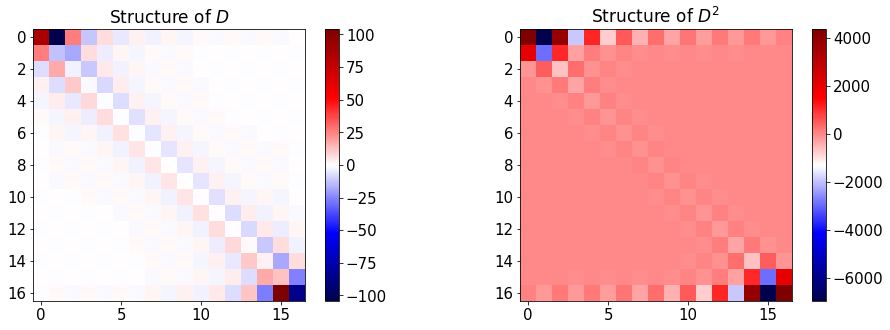

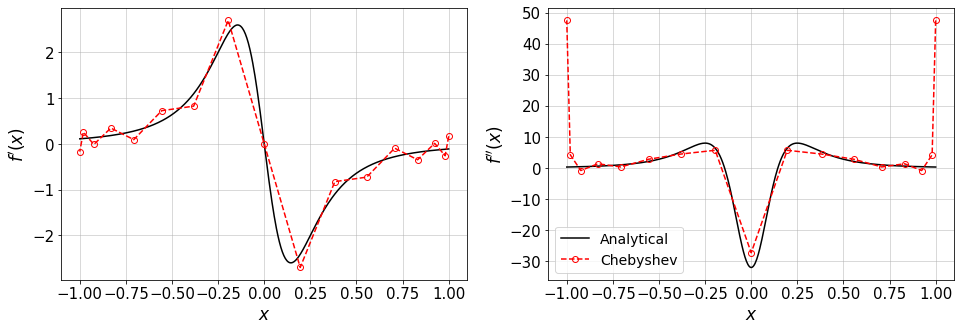

In [25]:
N=16   #Max order of Chebyshev polynomials
err1,err2=compareDiffs(N,plot_=True)

To get the **error-convergence plot**, we need to systematicaly change `N`:

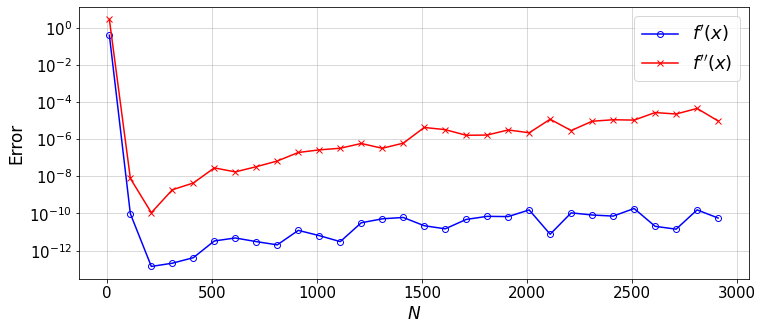

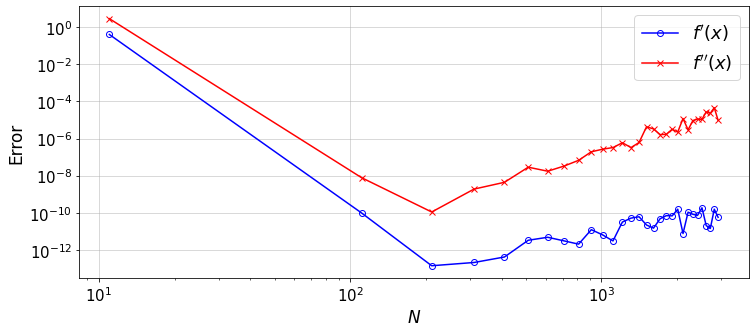

In [29]:
error1=[] #error in f'(x)
error2=[] #error in f''(x)
N=[]   
for N_ in range(11,3001,100):
    err1,err2=compareDiffs(N_)
    error1.append(err1)
    error2.append(err2)
    N.append(N_)
#plot
plt.figure(figsize=(12,5))
plt.semilogy(N,error1,'-ob',mfc='none',label=r'$f^\prime(x)$')
plt.plot(N,error2,'-xr',mfc='none',label=r'$f^{\prime \prime}(x)$')
plt.xlabel(r'$N$')
plt.ylabel('Error')
plt.grid()
plt.legend(loc='best',fontsize=18)
plt.show()
#plot
plt.figure(figsize=(12,5))
plt.loglog(N,error1,'-ob',mfc='none',label=r'$f^\prime(x)$')
plt.loglog(N,error2,'-xr',mfc='none',label=r'$f^{\prime \prime}(x)$')
plt.xlabel(r'$N$')
plt.ylabel('Error')
plt.grid()
plt.legend(loc='best',fontsize=18)
plt.show()

### Exercise and Discussion
* Why the error does not decrease after some $N$ and shows a gradual increase $\propto N^2$?
* What function could best describe the error reduction up to the $N$ at which the error reaches its minimum?  
* How the error in $D^3$ (and higher-order derivatives) would compare to the values plotted? or, why increasing the order of differentiation would lead to a lower accuracy?
* If you use the ChebyDiff method instead, what do you see? (lower accuracy, faster growth of round-off errors $\propto N^3$)

## Solve a Linear ODE using Chebyshev Method

In the lecture notes, the following ODE is considered, 

$$
\begin{equation}
u''(x) - H^2 u(x) = -1 \,,\quad  x\in[-1,1]
\end{equation}\label{ode1}\tag{1}
$$

with the boundary conditions $u(\pm 1)=0$, and $H$ as a constant. 
The exact solution of the equation is given by, 

$$
\begin{equation}
u(x) = \frac{1}{H^2}\left(1-\frac{\cosh Hx}{\cosh H}\right) \ .
\end{equation}
$$

Here, we write a short script to solve the equation using Chebyshev-collocation method for which the following equation is dervied in the lecture:

$$
(\mathbf{D}^2 -  H^2\mathbf{I}) \mathbf{u}_N = -\mathbb{1} \ ,
$$

In [16]:
uExact = lambda H,x : np.longdouble((1-np.cosh(H*x)/np.cosh(H))/H**2) #only for lBC=0, rBC=0

def chebySolver(N,H,lBC,rBC,plot_=False):
    """
    args:
       `N`: Max order of Chebyshev polynomials
       `H`: constant H in the equation
       `lBC`, `rBC`: value of the BC at -1 and +1, respectively
       `plot_`: if True, the numerical and exact solutions are plotted
    returns:
       `err`: magnitude of the error between the numerical and analytical solutions
    """
    n=N+1   #number of GLC points
    xGL=GLC_pts(N)    
    D=chebdif(n,2) #Gl points and D-matrices          
    A=D[1,:,:]-H**2.*np.eye(n) #matrix of coefficients    
    R=-np.ones(n) #RHS vector
    #apply BC
    A[0,:]=0.
    A[-1,:]=0.
    A[0,0]=1.
    A[-1,-1]=1.
    R[-1]=lBC   #we put lBC at end, since GLC points are from +1 to -1
    R[0]=rBC    
    u=np.linalg.solve(A,R) 
    #Error in computed u(x)
    uExact_=uExact(H,xGL)  
    if lBC==0 and rBC==0:
       err=norm((u-uExact_),np.inf)/norm(uExact_,np.inf)
    else:
       err=0.0 
    #plots
    if plot_:
       plt.figure(figsize=(12,5))
       plt.title('Chebyshev Method, N='+str(N),fontsize=14)
       plt.plot(xGL,u/np.max(u),'-ob',mfc='none',label='Chebyshev')
       if lBC==0 and rBC==0:
           plt.plot(xGL,uExact_/np.max(uExact_),'--r',label='Exact')
       plt.xlabel('$x$')
       plt.ylabel('$u(x)/u_0(x)$')
       plt.legend(loc='best')       
       plt.grid()
       plt.show()
    return err

Call the solver for arbitrary values of $H$ and $n$:

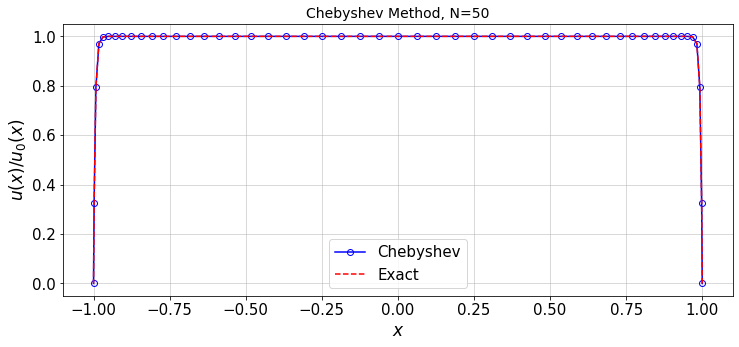

In [17]:
#---- Settings
N=50      #max order of Chebyshev function
H=200
lBC=0.0   #left BC value
rBC=0.0   #right BC value
#---------------
#Run the solver for a given resolution 
err=chebySolver(N,H,lBC,rBC,plot_=True)

### Chebyshev Method vs. Finite Difference Method
Equation ([1](#mjx-eqn-ode1)) can also be solved by finite difference method (FDM) over GLC (Gauss-Lobatto-Chebyshev) and equidistant grid points. 
The resulting solution can be compared to the solution obtained from the Chebyshev method. 

To implement the FDM, consider a mesh of $x_i$ over $[-1,1]$, where $i=0,1,\cdots,n-1$. 
The discretized Eq. ([1](#mjx-eqn-ode1)) is written as, 

$$
\begin{equation}
a_i  u_{i+1} -(b_i+H^2) u_i + c_i u_{i-1} = -1 \,, \quad i=1,2,\cdots,n-2 \,,
\end{equation}\label{fd1}\tag{2}
$$

with $u_0=\text{lBC}$ and $u_{n-1}=\text{rBC}$, where $\text{lBC}=\text{rBC}=0$. 
Also, 

$$
a_i=1/(\Delta x_i \Delta x_{i-1}) \,,\quad c_i=1/\Delta x_{i-1}^2 \,, \quad b_i=a_i+c_i \,,\quad
$$

and $\Delta x_i = x_{i+1}-x_{i}$. 

The following function solves Eq. ([1](#mjx-eqn-ode1)) by the above FDM scheme.

In [18]:
def FDsolver(n,H,lBC,rBC,plot_=False):
    """
    Finite difference method to solve the given ODE
    Two grids are considered: equidistant and Gauss-Lobatto-Chebyshev points
    """
    def FDsolver(n,x,H,lBC,rBC):
        n=len(x)
        A=np.zeros((n,n))
        R=-np.ones(n)
        for i in range(1,n-1):
            dx =x[i+1]-x[i]
            dxm=x[i]-x[i-1]
            a=1./(dx*dxm)
            c=1/dxm**2
            b=a+c            
            #FD matrix
            A[i,i-1]=c
            A[i,i]=-(b+H**2.)
            A[i,i+1]=a            
        #apply BC
        R[0]=lBC
        R[-1]=rBC
        A[0,:]=0.0
        A[-1,:]=0.0
        A[0,0]=1
        A[-1,-1]=1
        #plt.imshow(A) 
        #plt.colorbar()    
        #solve the linear system
        u=np.linalg.solve(A,R)  
        return u        
    #
    xGLC=GLC_pts(n) 
    xGLC=xGLC[::-1] #reverse the order: from -1 to +1, to be consistent with xUnif
    xUni=np.linspace(-1,1,n)  #equidistant points    
    #solve the ODE on these grids
    uGLC=FDsolver(n,xGLC,H,lBC,rBC)    
    uUni=FDsolver(n,xUni,H,lBC,rBC)
    #Error in computed u(x)       
    err_GLC=norm((uGLC-uExact(H,xGLC)),np.inf)/norm(uExact(H,xGLC),np.inf)
    err_Uni=norm((uUni-uExact(H,xUni)),np.inf)/norm(uExact(H,xUni),np.inf)
    
    if plot_:
       plt.figure(figsize=(12,5))
       plt.title('FDM solution',fontsize=15)
       plt.plot(xGLC,uGLC/np.max(uGLC),'-ob',mfc='none',label='GLC points')
       plt.plot(xUni,uUni/np.max(uUni),'-xr',mfc='none',label='Equidistant points')       
       plt.xlabel('$x$')
       plt.ylabel('$u(x)/u_0(x)$')
       plt.legend(loc='best')       
       plt.grid()
       plt.show()
    return err_GLC,err_Uni

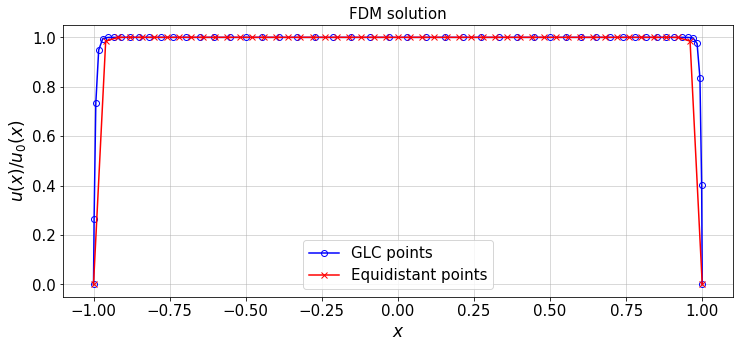

In [19]:
#FDM solution of the ODE
n=N+1   #number of points in FDM = N+1 (N: max Chebyshev polynomial order), for consistency
err_GLC,err_Uni=FDsolver(n,H,lBC,rBC,plot_=True)    

Now, we can compare the convergence of the solution $u$ to the exact solution $u_{\rm ex}$, where $u$ is obtained from:
* Chebyshev method on GLC points
* FDM on GLC points
* FDM on equidistant points

In all casese, we take $n=N+1$ points, where $N$ is the max order of the Chebyshev polynomials in the Chebyshev solution.

Note that the error is defined as,

$$
\begin{equation}
Error =\|u(x)-u_{\rm ex}(x)\|_\infty / \|u_{\rm ex}(x)\|_\infty \,.
\end{equation}
$$
To evaluate the error for each method, the exact solution is considered on the same grid as the numerical solution.

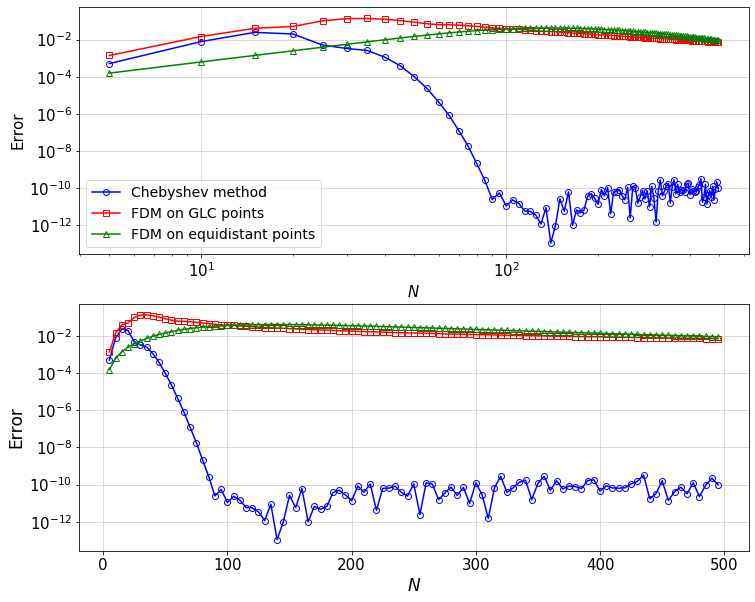

In [20]:
error_C=[] 
error_FD_C=[] 
error_FD_U=[] 
N=[]
for N_ in range(5,500,5):
    error_C.append(chebySolver(N_,H,lBC,rBC))
    err1_,err2_=FDsolver(N_+1,H,lBC,rBC) 
    error_FD_C.append(err1_)
    error_FD_U.append(err2_)
    N.append(N_)
#plot
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.loglog(N,error_C,'-ob',mfc='none',label='Chebyshev method')
plt.plot(N,error_FD_C,'-sr',mfc='none',label='FDM on GLC points')
plt.plot(N,error_FD_U,'-^g',mfc='none',label='FDM on equidistant points')
plt.xlabel(r'$N$',fontsize=15);plt.ylabel('Error',fontsize=15)
plt.xticks(fontsize=15);plt.yticks(fontsize=15)
plt.legend(loc='best',fontsize=14)
plt.grid()
plt.subplot(2,1,2)
plt.semilogy(N,error_C,'-ob',mfc='none',label='Chebyshev method')
plt.plot(N,error_FD_C,'-sr',mfc='none',label='FDM on GLC points')
plt.plot(N,error_FD_U,'-^g',mfc='none',label='FDM on equidistant points')
plt.xlabel(r'$N$')
plt.ylabel('Error')
plt.grid()
plt.show()

From the two different scalings of the error one can clearly see that the convergence is indeed spectral, i.e. faster than algebraic (i.e. the formal order increases with the number of grid points $N+1$). The error decreases linearly in a semi-log plot. Note also that the error increases algebraically (slope 1 in a log-log plot) before a maximum at $N\approx 20$. This is due to round-off errors in the derivative matrices.

**Discussion**
1. What is your conclusion about the accuracy of the Chebyshev and finite difference methods?
2. What are the pros and cons with each method?